In [16]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [14]:
sns.set()
np.random.seed(101)

In [4]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(alpha + beta*x, sigma);
}
"""

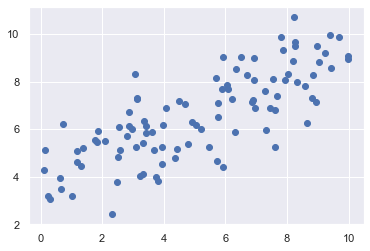

In [17]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10*np.random.rand(100)
y = np.random.normal(alpha+beta*x, scale=sigma)
plt.scatter(x, y)
plt.show()

In [19]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7885362138044f89df0f8630dff93869 NOW.


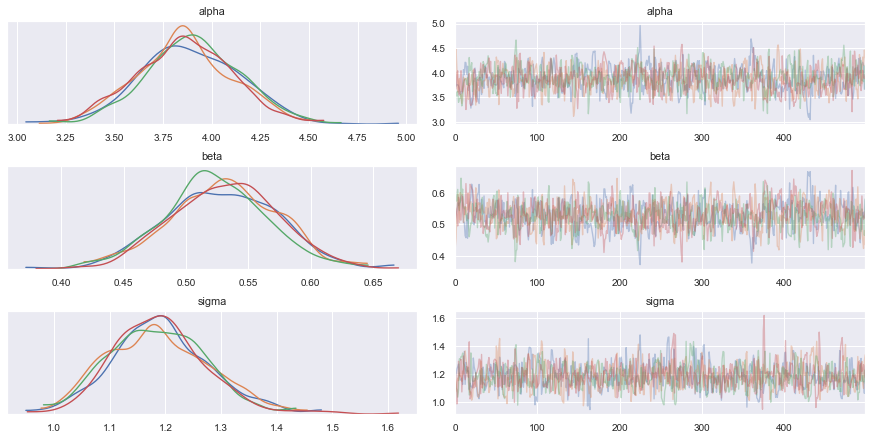

In [34]:
# !pip install arviz
import arviz
arviz.plot_trace(fit)
plt.show()

In [111]:
print(fit)

Inference for Stan model: anon_model_7885362138044f89df0f8630dff93869.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.88  9.1e-3   0.25    3.4   3.71   3.87   4.04   4.36    744    1.0
beta    0.53  1.6e-3   0.04   0.44    0.5   0.53   0.56   0.61    763    1.0
sigma   1.19  2.6e-3   0.09   1.03   1.13   1.19   1.24   1.37   1109    1.0
lp__  -65.99    0.05   1.25 -69.27 -66.58 -65.68 -65.09 -64.56    699    1.0

Samples were drawn using NUTS at Sat Apr 11 04:34:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [93]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'],
                  columns=summary_dict['summary_colnames'],
                  index=summary_dict['summary_rownames'])
alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

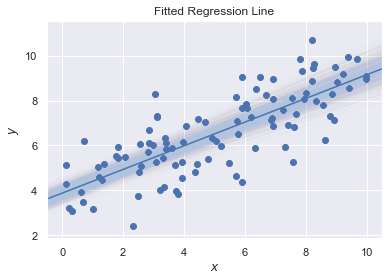

In [116]:
# Plotting regression line
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(1000):
    plt.plot(x_plot, alpha[i]+beta[i]*x_plot, color='lightsteelblue', alpha=0.005)
    
# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean*x_plot)
plt.scatter(x, y)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)
plt.show()

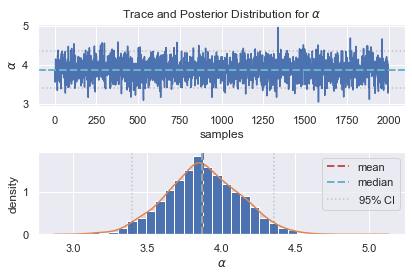

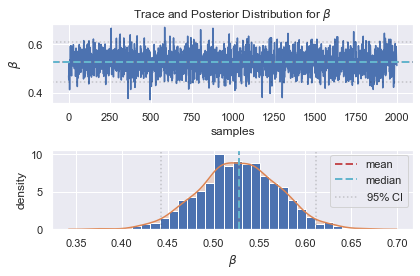

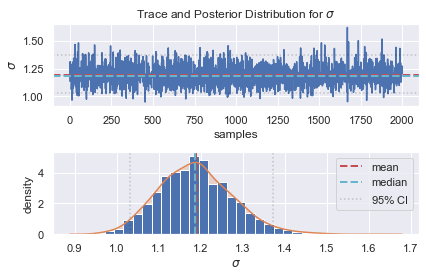

In [177]:
def plot_trace(param, param_name='parameter'):
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, color='k', linestyle=':', alpha=0.2)
    plt.axhline(cred_max, color='k', linestyle=':', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--', label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--', label='median')
    plt.axvline(cred_min, color='k', linestyle=':', label=r'95$\%$ CI', alpha=0.2)
    plt.axvline(cred_max, color='k', linestyle=':', alpha=0.2)
    plt.gcf().tight_layout()
    plt.legend()
    
plot_trace(alpha, r'$\alpha$')
plt.show()

plot_trace(beta, r'$\beta$')
plt.show()

plot_trace(sigma, r'$\sigma$')
plt.show()